In [187]:
#Importing the relevant modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from scipy import stats

Loading the file containing UKB metadata associated with leukemic patients. Specifying the dtype option as more than one dtype present

In [188]:
sample_df = pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/leu.tsv", sep='\t', header=0, low_memory= 'False')
inferred_dtypes = sample_df.dtypes
dtype_dict = {}
for col, dtype in inferred_dtypes.items():
    dtype_dict[col] = dtype.name
df = pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/leu.tsv", sep='\t', dtype=dtype_dict, engine='python')

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_2860\3597010048.py:1: DtypeWarning: Columns (19,20,21,23,24,25,29,30,31,98,99,100,106,107,108,110,111,451,453,454,478,479,735,736,737,739,740,741,751,752,753,755,756,757,775,776,777,779,780,781,783,784,785,814,815,816,818,819,820,822,823,824,826,827,828,829,830,831,833,834,835,838,839,840,842,843,844,846,847,848,870,871,872,874,875,876,878,879,880,882,883,884,886,887,888,890,891,892,898,899,900,902,903,904,906,907,908,910,911,912,914,915,916,918,919,920,922,923,924,926,927,928,930,931,932,958,959,960,962,963,964,966,967,968,970,971,972,974,975,976,978,979,980,982,983,984,986,987,988,990,991,992,994,995,996,1002,1003,1004,1010,1011,1012,1014,1015,1016,1026,1027,1028,1030,1031,1032,1038,1039,1040,1042,1043,1044,1046,1047,1048,1070,1071,1072,1074,1075,1076,1078,1079,1081,1082,1084,1085,1087,1088,1090,1091,1093,1094,1096,1097,1102,1103,1105,1106,1107,1109,1110,1111,1113,1114,1116,1117,1119,1120,1121,1127,1128,1129,1143,1144,1145,114

This data frame contains information on 2149 leukemia patients. It includes 25,590 features such as the date of first occurrence of various diseases, date of birth, duration of verbal interviews, eye test duration, ICD-10 codes for diseases, and diagnoses from each visit etc.

In [189]:
df

,eid,verbal_interview_duration_f3_0_0,verbal_interview_duration_f3_1_0,verbal_interview_duration_f3_2_0,verbal_interview_duration_f3_3_0,biometrics_duration_f4_0_0,biometrics_duration_f4_1_0,biometrics_duration_f4_2_0,biometrics_duration_f4_3_0,sample_collection_duration_f5_0_0,...,date_q95_first_reported_balanced_rearrangements_and_structural_markers_not_elsewhere_classified_f132596_0_0,source_of_report_of_q95_balanced_rearrangements_and_structural_markers_not_elsewhere_classified_f132597_0_0,date_q96_first_reported_turners_syndrome_f132598_0_0,source_of_report_of_q96_turners_syndrome_f132599_0_0,date_q97_first_reported_other_sex_chromosome_abnormalities_female_phenotype_not_elsewhere_classified_f132600_0_0,source_of_report_of_q97_other_sex_chromosome_abnormalities_female_phenotype_not_elsewhere_classified_f132601_0_0,date_q98_first_reported_other_sex_chromosome_abnormalities_male_phenotype_not_elsewhere_classified_f132602_0_0,source_of_report_of_q98_other_sex_chromosome_abnormalities_male_phenotype_not_elsewhere_classified_f132603_0_0,date_q99_first_reported_other_chromosome_abnormalities_not_elsewhere_classified_f132604_0_0,source_of_report_of_q99_other_chromosome_abnormalities_not_elsewhere_classified_f132605_0_0
0,1002912,712.0,NaN,NaN,NaN,604.0,NaN,NaN,NaN,257.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1002951,541.0,NaN,NaN,NaN,570.0,NaN,NaN,NaN,203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1005217,583.0,NaN,NaN,NaN,536.0,NaN,NaN,NaN,186.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1009538,486.0,NaN,NaN,NaN,504.0,NaN,NaN,NaN,266.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1009715,437.0,NaN,NaN,NaN,561.0,NaN,NaN,NaN,309.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,6006271,703.0,730.0,478.0,NaN,1218.0,966.0,479.0,NaN,250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2145,6018053,520.0,NaN,NaN,NaN,722.0,NaN,NaN,NaN,273.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2146,6020766,695.0,NaN,NaN,NaN,316.0,NaN,NaN,NaN,261.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2147,6024287,489.0,NaN,NaN,NaN,269.0,NaN,NaN,NaN,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The ICD-10 codes assigned at the time of diagnosis for each patient during each visit were used to map each patient to one or more comorbidities using the ICD package. A custom mapping parameter was employed, where each broad chapter in the first occurrence data had numerous associated ICD codes. The resulting data frame contains columns representing the broad chapters or comorbidities associated with all 2149 patients.

In [190]:
first_occur= pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/comor3.csv.xls")

The `icd_df` data frame has columns representing disease diagnoses at subsequent visits for each patient, using three- to four-letter codes. These codes are categorized into 16 broad chapters based on the first occurrence data.

In [191]:
first_occur= first_occur.set_index('eid')

In [192]:
first_occur

,inf_para_codes,blood_codes,endocrine_codes,mental_codes,nervous_codes,eye_codes,ear_codes,circ_codes,resp_codes,digestive_codes,skin_codes,muscle_codes,genitourino_codes,pregnancy_codes,perinatal_codes,congenital_codes
eid,,,,,,,,,,,,,,,,
1002912,False,False,True,False,False,False,False,True,True,True,True,True,False,False,False,False
1002951,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False
1005217,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False
1009538,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
1009715,True,True,False,True,False,False,True,False,True,True,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006271,True,True,True,True,True,False,False,True,True,False,False,False,True,False,False,False
6018053,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
6020766,False,True,True,True,True,True,False,True,True,True,True,True,True,False,False,False


In [193]:
icd_columns= df.columns[df.columns.str.contains('f41270_0')]
icd_df= df[['eid'] + list(icd_columns)]

#setting the eid column as the index
icd_df= icd_df.set_index('eid')

A set of 'first occurrence' data fields has been created to map clinical codes from primary care, hospital inpatient admissions, death records, and self-reported medical conditions to 3-character ICD-10 codes. For each participant, these fields provide the date when each code first appeared in any source. The first_occur_date_df contains the dates of all the first diagnosis.

In [194]:
first_occur_date_df= df[df.columns[df.columns.str.contains('f13')]]
first_occur_date_df= first_occur_date_df[first_occur_date_df.columns[first_occur_date_df.columns.str.contains('date')]]
first_occur_date_df['eid']= icd_df.index
first_occur_date_df= first_occur_date_df.set_index('eid')

In [195]:
#Extracting the date of birth of each patient from the original data frame and setting eid as the index
dob_df= df[df.columns[df.columns.str.contains('f34_0')]]
dob_df['eid']= icd_df.index
dob_df= dob_df.set_index('eid')

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_2860\4069371386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dob_df['eid']= icd_df.index


Function to calculate the age of onset of each first occurence disease by subtracting the date of birth from the date of diagnosis of first occurence of a specific icd code.

In [196]:
def calculate_age_onset(date, dob):
    date_diag= int(date.split('-')[0])
    return date_diag- dob

In [197]:
#merging the date of birth column with the first_occur_date dataframe
first_occur_date_df= first_occur_date_df.merge(dob_df[['year_of_birth_f34_0_0']], left_index= True, right_index= True)

creating a function which returns a data frame containing the age of onset of each of the first occurence diseases as columns. It iterates through the rows of the input first_occur_date_df. For each diagnosis date that is valid, it calculates the age at onset. Stores the results in a dictionary. Converts the dictionary into a DataFrame. Pivots the DataFrame to get the desired structure, where each row corresponds to a patient (eid), and each column corresponds to a diagnosis (diag) with the age of onset as the values.

In [198]:
def create_age_onset_pivot(first_occur_date_df):
    age_onset_dict = {}
    
    for index, row in first_occur_date_df.iterrows():
        for col in first_occur_date_df.columns:
            dob = row['year_of_birth_f34_0_0']
            if col != 'year_of_birth_f34_0_0':
                value = row[col]
                if pd.notna(value) and value not in ['1900-01-01', '1901-01-01', '1902-02-02', '1903-03-03', '1909-09-09', '2037-07-07']:
                    age_onset = calculate_age_onset(value, dob)
                    age_onset_dict[(index, col)] = age_onset

    rows = []
    for key, value in age_onset_dict.items():
        eid = key[0]
        diag = key[1]
        age = value
        rows.append((eid, diag, age))

    # Creating the DataFrame from the list of tuples
    age_onset_df = pd.DataFrame(rows, columns=['eid', 'diag', 'age'])

    # Pivoting the DataFrame to get the desired structure
    pivot_df = age_onset_df.pivot(index='eid', columns='diag', values='age')

    return pivot_df


In [199]:
#applying the function and replacing the NaN values with 999 
#it's important to choose a placeholder value that does not conflict with the actual data values. 
#In this case, if ages are being calculated and 999 is used, it is clear that 999 is not a possible age and thus represents missing data.
pivot_df = create_age_onset_pivot(first_occur_date_df)
pivot_df[pivot_df.columns]= pivot_df[pivot_df.columns].fillna(999).astype(int)

In [200]:
#Extracting the age of leukaemia onset from the original dataframe
cancer_onset= df[df.columns[df.columns.str.contains('f40008_0')]]
cancer_onset['eid']= icd_df.index
cancer_onset= cancer_onset.set_index('eid')

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_2860\1192985538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_onset['eid']= icd_df.index


After the removal of the invalid dates, the total number of patients came down to 2135 in the pivot_df data frame. This dataframe consists of 799 columns, each representing a specific icd code and the values representing the age of diagnosis.

In [201]:
pivot_df

diag,date_a02_first_reported_other_salmonella_infections_f130004_0_0,date_a03_first_reported_shigellosis_f130006_0_0,date_a04_first_reported_other_bacterial_intestinal_infections_f130008_0_0,date_a05_first_reported_other_bacterial_foodborne_intoxications_f130010_0_0,date_a07_first_reported_other_protozoal_intestinal_diseases_f130014_0_0,date_a08_first_reported_viral_and_other_specified_intestinal_infections_f130016_0_0,date_a09_first_reported_diarrhoea_and_gastroenteritis_of_presumed_infectious_origin_f130018_0_0,date_a15_first_reported_respiratory_tuberculosis_bacteriologically_and_histologically_confirmed_f130020_0_0,date_a16_first_reported_respiratory_tuberculosis_not_confirmed_bacteriologically_or_histologically_f130022_0_0,date_a28_first_reported_other_zoonotic_bacterial_diseases_not_elsewhere_classified_f130046_0_0,...,date_q82_first_reported_other_congenital_malformations_of_skin_f132574_0_0,date_q83_first_reported_congenital_malformations_of_breast_f132576_0_0,date_q85_first_reported_phakomatoses_not_elsewhere_classified_f132580_0_0,date_q89_first_reported_other_congenital_malformations_not_elsewhere_classified_f132586_0_0,date_q90_first_reported_downs_syndrome_f132588_0_0,date_q91_first_reported_edwards_syndrome_and_pataus_syndrome_f132590_0_0,date_q92_first_reported_other_trisomies_and_partial_trisomies_of_the_autosomes_not_elsewhere_classified_f132592_0_0,date_q93_first_reported_monosomies_and_deletions_from_the_autosomes_not_elsewhere_classified_f132594_0_0,date_q98_first_reported_other_sex_chromosome_abnormalities_male_phenotype_not_elsewhere_classified_f132602_0_0,date_q99_first_reported_other_chromosome_abnormalities_not_elsewhere_classified_f132604_0_0
eid,,,,,,,,,,,,,,,,,,,,,
1002912,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,44,999,999,999
1002951,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,999
1005217,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,999
1009538,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,999
1009715,999,999,60,999,999,999,60,999,999,999,...,999,999,999,999,999,999,999,999,999,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006271,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,999
6018053,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,999
6020766,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,999


In [202]:
#merging the age of onset of cancer with the data frame containing the age of onset of each of the first occurence diseases
pivot_df= pivot_df.merge(cancer_onset[['age_at_cancer_diagnosis_f40008_0_0']], left_index= True, right_index= True)


In [203]:
#dropping the Na values
#Brings down the total number of patients to 1564
pivot_df.dropna(inplace=True)

In [204]:
pivot_df

,date_a02_first_reported_other_salmonella_infections_f130004_0_0,date_a03_first_reported_shigellosis_f130006_0_0,date_a04_first_reported_other_bacterial_intestinal_infections_f130008_0_0,date_a05_first_reported_other_bacterial_foodborne_intoxications_f130010_0_0,date_a07_first_reported_other_protozoal_intestinal_diseases_f130014_0_0,date_a08_first_reported_viral_and_other_specified_intestinal_infections_f130016_0_0,date_a09_first_reported_diarrhoea_and_gastroenteritis_of_presumed_infectious_origin_f130018_0_0,date_a15_first_reported_respiratory_tuberculosis_bacteriologically_and_histologically_confirmed_f130020_0_0,date_a16_first_reported_respiratory_tuberculosis_not_confirmed_bacteriologically_or_histologically_f130022_0_0,date_a28_first_reported_other_zoonotic_bacterial_diseases_not_elsewhere_classified_f130046_0_0,...,date_q83_first_reported_congenital_malformations_of_breast_f132576_0_0,date_q85_first_reported_phakomatoses_not_elsewhere_classified_f132580_0_0,date_q89_first_reported_other_congenital_malformations_not_elsewhere_classified_f132586_0_0,date_q90_first_reported_downs_syndrome_f132588_0_0,date_q91_first_reported_edwards_syndrome_and_pataus_syndrome_f132590_0_0,date_q92_first_reported_other_trisomies_and_partial_trisomies_of_the_autosomes_not_elsewhere_classified_f132592_0_0,date_q93_first_reported_monosomies_and_deletions_from_the_autosomes_not_elsewhere_classified_f132594_0_0,date_q98_first_reported_other_sex_chromosome_abnormalities_male_phenotype_not_elsewhere_classified_f132602_0_0,date_q99_first_reported_other_chromosome_abnormalities_not_elsewhere_classified_f132604_0_0,age_at_cancer_diagnosis_f40008_0_0
eid,,,,,,,,,,,,,,,,,,,,,
1002912,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,44,999,999,999,55.2
1002951,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,53.5
1005217,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,56.7
1009538,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,55.0
1009715,999,999,60,999,999,999,60,999,999,999,...,999,999,999,999,999,999,999,999,999,58.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004309,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,63.2
6018053,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,72.2
6020766,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,41.5


Creating a function called extract_chapters that merges columns containing codes associated with broad disease classifications, referred to as chapters, in the UK Biobank's first occurrence field under the health outcomes category. Each chapter represents a 'comorbidity.' For example, inf_para_dict contains all ICD codes related to infectious and parasitic diseases, while nervous_dict includes ICD codes for neurological diseases or diseases of the nervous system.

In [205]:
def extract_chapters(pivot_df):
    #creating a sub-function which extracts the minimum age of diagnosis associated with each first occurrence chapter 
    #or the code associated with the minimum age under a specific chapter.
    #returns a dictionary with the name of the chapter as the dict name and the minimum age associaed with it as the value and eid as the key
        def extract_min_values(pivot_df, indexer, max_col=None):
            if isinstance(indexer, slice):
                selected_columns = pivot_df.columns[indexer]
            else:
                selected_columns = pivot_df.columns[indexer]

            if max_col is not None:
                selected_columns = selected_columns[:max_col]

            selected_col = pivot_df[selected_columns]

            min_values_dict = {}
            for eid, row in selected_col.iterrows():
                min_value = row.min()
                min_values_dict[eid] = min_value

            return min_values_dict

        all_col = pivot_df.columns

        #creating 16 dictionaries corresponding to each first occurrence chapter
        #each consisting of the minimum age of diagnosis under the specific chapter as the value and the eid as the key
        inf_para_dict = extract_min_values(pivot_df, all_col.str.contains('date_a') | all_col.str.contains('date_b'))
        blood_dict = extract_min_values(pivot_df, all_col.str.contains('date_d'), 40)
        endocrine_dict = extract_min_values(pivot_df, all_col.str.contains('date_e'), 91)
        mental_dict = extract_min_values(pivot_df, all_col.str.contains('date_f'), 100)
        nervous_dict = extract_min_values(pivot_df, all_col.str.contains('date_g'), 100)
        
        date_h_columns = all_col[all_col.str.contains('date_h')]
        eye_dict = extract_min_values(pivot_df, slice(0, 43))  
        ear_dict = extract_min_values(pivot_df, slice(43, 96))  
        
        circ_dict = extract_min_values(pivot_df, all_col.str.contains('date_i'), 100)
        resp_dict = extract_min_values(pivot_df, all_col.str.contains('date_j'), 100)
        digestive_dict = extract_min_values(pivot_df, all_col.str.contains('date_k'), 100)
        skin_dict = extract_min_values(pivot_df, all_col.str.contains('date_l'), 100)
        muscle_dict = extract_min_values(pivot_df, all_col.str.contains('date_m'), 100)
        genitourino_dict = extract_min_values(pivot_df, all_col.str.contains('date_n'), 100)
        pregnancy_dict = extract_min_values(pivot_df, all_col.str.contains('date_o'), 100)
        perinatal_dict = extract_min_values(pivot_df, all_col.str.contains('date_p'), 100)
        congenital_dict = extract_min_values(pivot_df, all_col.str.contains('date_q'), 100)

        #creating a list of all the dictionaries
        dict_list = [inf_para_dict, blood_dict, endocrine_dict,
                     mental_dict, nervous_dict, eye_dict, ear_dict,
                     circ_dict, resp_dict, digestive_dict, skin_dict,
                     muscle_dict, genitourino_dict, pregnancy_dict, 
                     perinatal_dict, congenital_dict]
    
        #creating a set containing all the unique eids in the dictionaries
        all_eids = set()
        for d in dict_list:
            all_eids.update(d.keys())

        #Initialize data dictionary 
        data = {}
        #enumerate(dict_list) provides both the index i and the dictionary d from dict_list.
        #dict_list is a list of dictionaries.
        #i is the index of the current dictionary in dict_list.
        #d is the current dictionary being processed.
    
        for i, d in enumerate(dict_list):
            #dict_name is a string that uniquely identifies each dictionary (dict_0, dict_1, etc.).
            #data[dict_name] = {} initializes an empty dictionary under the key dict_name in data.
            
            dict_name = f'dict_{i}'
            data[dict_name] = {}
            
           # For each eid in all_eids:
            #d.get(eid, None) attempts to retrieve the value associated with eid in the current dictionary d.
            #If eid is not found in d, None is returned by default.
            #This value (either the found value or None) is assigned to data[dict_name][eid].
            
            for eid in all_eids:
                data[dict_name][eid] = d.get(eid, None)
                
        #converting the dictionary into a dataframe and renaming the columns
        age_df = pd.DataFrame(data)
        age_df.index = all_eids
        age_df.columns = ['infectious_parasitic', 'blood', 'endocrine_system', 'mental', 'nervous_system', 'eye', 'ear',
                          'circulatory_system', 'respiratory_system', 'digestive_system', 'skin', 'musculoskeletal_system', 'genitourinary_system', 'pregnancy',
                          'perinatal', 'congenital']
        age_df = age_df.sort_index(axis=0)
        return age_df

In [206]:
#applying the function
age_df= extract_chapters(pivot_df)

In [207]:
age_df

,infectious_parasitic,blood,endocrine_system,mental,nervous_system,eye,ear,circulatory_system,respiratory_system,digestive_system,skin,musculoskeletal_system,genitourinary_system,pregnancy,perinatal,congenital
1002912,62,999,52,999,999,62,999,50,61,55,54,54,999,999,999,44
1002951,65,57,57,999,999,65,57,55,60,64,999,999,73,999,999,999
1005217,999,999,70,999,999,999,999,999,999,70,999,53,999,999,999,999
1009538,999,999,999,999,999,999,999,52,70,52,70,999,999,999,999,999
1009715,46,60,999,53,999,46,60,999,60,58,58,999,50,999,999,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004309,66,999,50,999,999,999,66,66,999,51,999,66,66,999,999,999
6018053,999,72,999,999,999,999,72,999,65,55,60,62,41,999,999,999
6020766,61,72,74,61,57,999,61,71,54,68,58,57,44,999,999,68
6024287,72,999,999,999,999,999,72,59,72,999,71,999,999,999,999,999


Creating a function that sets the ages for all diseases diagnosed after the onset of leukemia to 999. This ensures that only diseases diagnosed before leukemia are considered when predicting the age of onset of leukemia. The aim is to identify which types of comorbidities are significant in the lead-up to the cancer diagnosis.

In [208]:
def pre_condition(df, cancer_age_col= 'age_at_cancer_diagnosis_f40008_0_0'):
    for index, row in df.iterrows():
        cancer_age= row[cancer_age_col]
        for col in df.columns:
            if col != cancer_age_col and pd.notnull(row[col]) and row[col] > cancer_age:
                df.at[index, col]= 999
    return df

In [209]:
#merging the column containing the age of cancer onset with the age_df
age_df= age_df.merge(cancer_onset[['age_at_cancer_diagnosis_f40008_0_0']], left_index= True, right_index= True)
age_df= pre_condition(age_df)

In [210]:
age_df.to_csv('C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/age_df.csv')

In [211]:
#defining features and target
#the last column contains the age of cancer diagnosis or the target
features= age_df.columns[:-1]
target= 'age_at_cancer_diagnosis_f40008_0_0'

The data was first split into 60% training set and 40% testing set. The 40% test set was split again into 20% testing set_1 and 20% testing set_2. This split was utilised to check the performance of each model and choose the best according to the MSE and R-squared values.

In [212]:
#splitting the data into first 60% train and 40% temp
train_df, temp_df= train_test_split(age_df, test_size=0.4, random_state=42)
#then split the temp into two equal halves 20% and 20%
test_df_1, test_df_2= train_test_split(temp_df, test_size=0.5, random_state=42)

The first occurrence chapters with the age of onset of the earliest detected disease corresponding to a particular chapter were set as the features. While the age of cancer onset was treated as the target variable. Only diseases diagnosed prior to leukaemia diagnosis were used.

In [213]:
#seperating features and target in each set
X_train= train_df[features]
y_train= train_df[target]

X_test_1= test_df_1[features]
y_test_1= test_df_1[target]

X_test_2= test_df_2[features]
y_test_2= test_df_2[target]

In [214]:
#RandomForest model
rf= RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [215]:
#testing the model on training set 1
y_pred_rf= rf.predict(X_test_1)

In [216]:
#storing the mean_squared_error in a variable for comparison with other models
mse_rf= mean_squared_error(y_test_1, y_pred_rf)

In [217]:
#DecisionTree model
tree= DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [218]:
#testing the model on training set 1
y_pred_tree= tree.predict(X_test_1)

In [219]:
#storing the mean_squared_error in a variable for comparison with other models
mse_tree= mean_squared_error(y_test_1, y_pred_tree)

In [220]:
#XGB model
xgb= xgb.XGBRegressor(objective= 'reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [221]:
#testing the model on testing set 1
y_pred_xgb= tree.predict(X_test_1)

In [222]:
#storing the mean_squared_error in a variable for comparison with other models
mse_xgb= mean_squared_error(y_test_1, y_pred_xgb)

In [223]:
#calculating r2 scores to evaluate model performance
r2_rf= r2_score(y_test_1, y_pred_rf)
r2_tree= r2_score(y_test_1, y_pred_tree)
r2_xgb= r2_score(y_test_1, y_pred_xgb)


In [224]:
#storing the mse and r2 information for testing set 1 for each model in a dataframe
performance_dict= {'random_forest': [mse_rf, r2_rf], 'decision_tree':[mse_tree, r2_tree], 'xgb':[mse_xgb, r2_xgb]}
performance_df= pd.DataFrame(list(performance_dict.values()), index= list(performance_dict.keys()), columns= ['mse', 'r_squared'])

In [225]:
performance_df

,mse,r_squared
random_forest,55.372207,0.465884
decision_tree,82.928210,0.200081
xgb,82.928210,0.200081


In [226]:
#testing the models on testing set 2
y_pred_rf1= rf.predict(X_test_2)
y_pred_tree1= tree.predict(X_test_2)
y_pred_xgb1= tree.predict(X_test_2)

#storing the mse values for testing set 2 in respective variables
mse_rf1= mean_squared_error(y_test_2, y_pred_rf1)
mse_tree1= mean_squared_error(y_test_2, y_pred_tree1)
mse_xgb1= mean_squared_error(y_test_2, y_pred_xgb1)

#calculating r2 scores to evaluate model performance for testing set 2
r2_rf1= r2_score(y_test_2, y_pred_rf1)
r2_tree1= r2_score(y_test_2, y_pred_tree1)
r2_xgb1= r2_score(y_test_2, y_pred_xgb1)


In [227]:
#storing the mse and r2 values of each model in a data frame
performance_dict1= {'random_forest': [mse_rf1, r2_rf1], 'decision_tree':[mse_tree1, r2_tree1], 'xgb':[mse_xgb1, r2_xgb1]}
performance_df1= pd.DataFrame(list(performance_dict.values()), index= list(performance_dict.keys()), columns= ['mse', 'r_squared'])


In [228]:
performance_df1

,mse,r_squared
random_forest,55.372207,0.465884
decision_tree,82.928210,0.200081
xgb,82.928210,0.200081


Utilising RandomForest to train the model again on 80% of the data since it gives the least MSE and highest r-squared values and is thus the most accurate model among the three.

In [229]:
#splitting the data into first 80% train and 20% test to run random forest again
train_df1, test_df1= train_test_split(age_df, test_size=0.2, random_state=42)

In [230]:
X_train1= train_df1[features]
y_train1= train_df1[target]

X_test= test_df1[features]
y_test= test_df1[target]


In [231]:
rf2= RandomForestRegressor(n_estimators=100, random_state=42)
rf2.fit(X_train1, y_train1)

RandomForestRegressor(random_state=42)

In [232]:
y_pred1= rf2.predict(X_test)
mse= mean_squared_error(y_test, y_pred1)
r2_rf2= r2_score(y_test, y_pred1)

In [233]:
print(mse)
print(r2_rf2)

55.03986819549418
0.4407370299395973


In [234]:
#Reading in the master table containing charlson comorbidities along with the type of leukaemia each patient belongs to, sex, IMD score, IMD category and age of death
charl_master= pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/charl_master.csv", sep= ',', header= 0)

In [235]:
charl_master= charl_master.set_index('eid')

In [236]:
charl_master

,myocardial_infarction,congestive_heart_failure,periphral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,connective_tissue_disease_rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_wo_complications,...,ALL,CLL,sex_f31_0_0,index_of_multiple_deprivation_england_f26410_0_0,age_at_death_f40007_0_0,PC1,PC2,PC3,PC4,category
eid,,,,,,,,,,,,,,,,,,,,,
1002912,1,0,0,0,0,0,0,0,0,0,...,False,False,0,NaN,62.4,-0.018540,-0.055130,-0.239557,-0.273661,NaN
1002951,1,0,0,1,0,1,0,0,0,1,...,True,False,0,NaN,NaN,0.613221,-0.317338,-0.154664,-0.159460,NaN
1005217,0,0,0,0,0,0,0,0,0,1,...,False,True,0,10.35,NaN,0.024748,-0.134066,-0.207266,0.257855,high
1009538,0,0,0,0,0,0,0,0,0,0,...,True,False,0,NaN,NaN,-0.266016,-0.047984,-0.009746,0.051415,NaN
1009715,0,0,0,0,0,1,0,0,0,0,...,False,False,0,NaN,60.0,-0.128377,0.024726,-0.093342,-0.083380,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006271,0,0,0,1,0,0,0,0,0,1,...,False,False,0,60.84,70.5,0.228106,-0.382900,0.158743,0.300412,high
6018053,0,0,0,0,0,0,0,0,0,0,...,True,False,1,18.46,NaN,-0.266016,-0.047984,-0.009746,0.051415,high
6020766,0,0,0,0,0,0,0,0,1,0,...,False,True,1,9.27,75.2,0.085880,1.418210,0.542504,0.643727,high


In [237]:
#Merging the category column from the master table with the data frame containing the ages of onset of each first occurrence chapter
age_df_new= age_df.merge(charl_master[['category']], left_index= True, right_on= 'eid')

In [238]:
age_df_new

,infectious_parasitic,blood,endocrine_system,mental,nervous_system,eye,ear,circulatory_system,respiratory_system,digestive_system,skin,musculoskeletal_system,genitourinary_system,pregnancy,perinatal,congenital,age_at_cancer_diagnosis_f40008_0_0,category
eid,,,,,,,,,,,,,,,,,,
1002912,999,999,52,999,999,999,999,50,999,55,54,54,999,999,999,44,55.2,NaN
1002951,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999,53.5,NaN
1005217,999,999,999,999,999,999,999,999,999,999,999,53,999,999,999,999,56.7,high
1009538,999,999,999,999,999,999,999,52,999,52,999,999,999,999,999,999,55.0,NaN
1009715,46,999,999,53,999,46,999,999,999,58,58,999,50,999,999,999,58.9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004309,999,999,50,999,999,999,999,999,999,51,999,999,999,999,999,999,63.2,NaN
6018053,999,72,999,999,999,999,72,999,65,55,60,62,41,999,999,999,72.2,high
6020766,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999,41.5,high


Subsetting the age_df data into IMD 'high' and 'low' categories to train the model seperately on both.

In [239]:
age_df_high_sub = age_df_new[age_df_new['category'] == 'high']

In [240]:
age_df_low_sub = age_df_new[age_df_new['category'] == 'low']

TRAINING THE MODEL ON THE HIGH DEPRIVATION SUBSET

In [241]:
#splitting the data into first 80% train and 20% test to run random forest again
train_df_high, test_df_high= train_test_split(age_df_high_sub, test_size=0.2, random_state=42)

In [242]:
features= age_df_high_sub.columns[:-2]
target= 'age_at_cancer_diagnosis_f40008_0_0'

In [243]:
X_train_high= train_df_high[features]
y_train_high= train_df_high[target]

X_test_high= test_df_high[features]
y_test_high= test_df_high[target]

rf_final_high= RandomForestRegressor(n_estimators=100, random_state=42)
rf_final_high.fit(X_train_high, y_train_high)

RandomForestRegressor(random_state=42)

SHAP analysis to determine the features having the highest impact on the model's prediction.

In [244]:
#Creating an instance of the explainer which consists of the most important features
explainer= shap.Explainer(rf_final_high)

#Calculating the SHAP values associated with a particular feature
shap_values= explainer.shap_values(X_test_high)

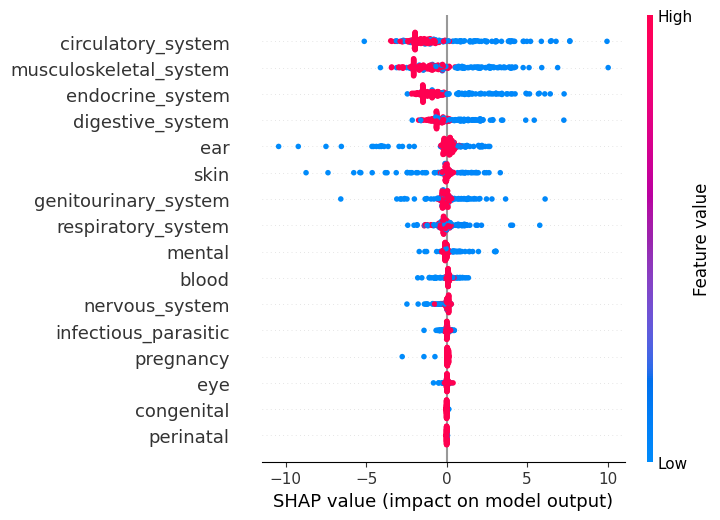

In [245]:
shap.summary_plot(shap_values, X_test_high, show=False)
plt.gcf().set_size_inches(7, 5)
plt.show()

TRAINING THE MODEL ON THE LOW DEPRIVATION SUBSET

In [246]:
#splitting the data into first 80% train and 20% test to run random forest again
train_df_low, test_df_low= train_test_split(age_df_low_sub, test_size=0.2, random_state=42)

In [247]:
features= age_df_low_sub.columns[:-2]
target= 'age_at_cancer_diagnosis_f40008_0_0'

In [248]:
X_train_low= train_df_low[features]
y_train_low= train_df_low[target]

X_test_low= test_df_low[features]
y_test_low= test_df_low[target]

rf_final_low= RandomForestRegressor(n_estimators=100, random_state=42)
rf_final_low.fit(X_train_low, y_train_low)

RandomForestRegressor(random_state=42)

In [249]:
explainer= shap.Explainer(rf_final_low)
shap_values= explainer.shap_values(X_test_low)

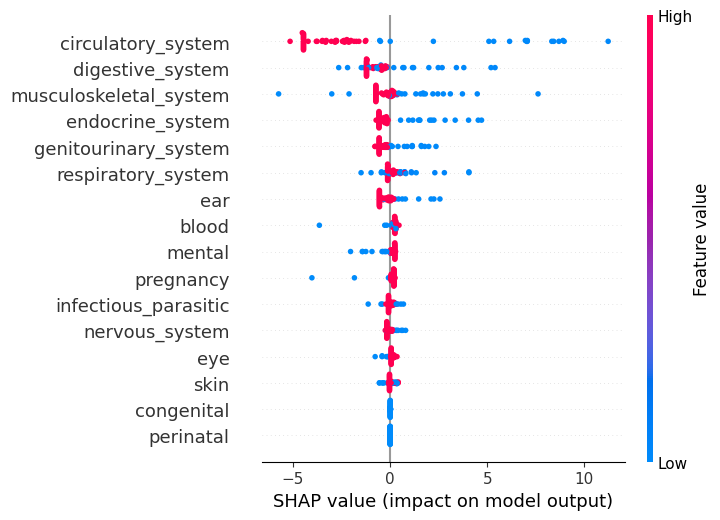

In [250]:
shap.summary_plot(shap_values, X_test_low, show=False)
plt.gcf().set_size_inches(7, 5)
plt.show()

Saving the models for future use.

In [251]:
dump(rf_final_high, 'rf_final_high_model.joblib')
loaded_rf_final_high = load('rf_final_high_model.joblib')

In [252]:
dump(rf_final_low, 'rf_final_low_model.joblib')
loaded_rf_final_low = load('rf_final_low_model.joblib')

In [253]:
# Performing cross-validation for low subset
cv_scores_low = cross_val_score(loaded_rf_final_low, X_train_low, y_train_low, cv=5)  
# Performing cross-validation for high subset
cv_scores_high = cross_val_score(loaded_rf_final_high, X_train_high, y_train_high, cv=5)  

In [254]:
# Computing the mean and standard deviation of the cross-validation scores
mean_score_low = np.mean(cv_scores_low)
std_dev_low = np.std(cv_scores_low)

# Computing the 95% confidence interval
# Assuming normal distribution, CI = mean ± 1.96 * (std_dev / sqrt(n))
confidence_interval_low = 1.96 * (std_dev_low / np.sqrt(len(cv_scores_low)))

print(f"Mean Score: {mean_score_low:.4f}")
print(f"95% Confidence Interval: [{mean_score_low - confidence_interval_low:.4f}, {mean_score_low + confidence_interval_low:.4f}]")


Mean Score: 0.3002
95% Confidence Interval: [0.2489, 0.3515]


In [255]:
# Computing the mean and standard deviation of the cross-validation scores
mean_score_high = np.mean(cv_scores_high)
std_dev_high = np.std(cv_scores_high)

# Computing the 95% confidence interval
# CI = mean ± 1.96 * (std_dev / sqrt(n))
confidence_interval_high = 1.96 * (std_dev_high / np.sqrt(len(cv_scores_high)))

print(f"Mean Score: {mean_score_high:.4f}")
print(f"95% Confidence Interval: [{mean_score_high - confidence_interval_high:.4f}, {mean_score_high + confidence_interval_high:.4f}]")


Mean Score: 0.3970
95% Confidence Interval: [0.3587, 0.4353]


In [256]:
#Calculating the residual value for low model
y_pred_low = loaded_rf_final_low.predict(X_test_low)
residuals_low = y_test_low - y_pred_low

# Calculating the residual standard error
residual_std_low = np.std(residuals_low)


In [257]:
#Calculating the residual value for high model
y_pred_high = loaded_rf_final_high.predict(X_test_high)
residuals_high = y_test_high - y_pred_high

# Calculating the residual standard error
residual_std_high = np.std(residuals_high)

Creating a function to get the prediction intervals for each patient. t-value is used for the calculation of the margin of error, which is then added and subtracted from the prediction to get the upper and lower range of the CI.

In [258]:
def get_prediction_intervals(predictions, residual_std, alpha=0.05):
    n = len(predictions)
    t_val = stats.t.ppf(1 - alpha/2, df=n-1)  # t-value for the given confidence level
    margin_of_error = t_val * residual_std
    return predictions - margin_of_error, predictions + margin_of_error

# Computing the intervals
lower_bound_low, upper_bound_low = get_prediction_intervals(y_pred_low, residual_std_low)
lower_bound_high, upper_bound_high = get_prediction_intervals(y_pred_high, residual_std_high)

# Printing some of the intervals
for i in range(5):  
    print(f"Prediction: {y_pred_low[i]:.2f}, Interval: [{lower_bound_low[i]:.2f}, {upper_bound_low[i]:.2f}]")

for i in range(5):  
    print(f"Prediction: {y_pred_high[i]:.2f}, Interval: [{lower_bound_high[i]:.2f}, {upper_bound_high[i]:.2f}]")


Prediction: 52.72, Interval: [37.15, 68.29]
Prediction: 66.18, Interval: [50.61, 81.75]
Prediction: 62.84, Interval: [47.27, 78.41]
Prediction: 70.32, Interval: [54.76, 85.89]
Prediction: 70.80, Interval: [55.24, 86.37]
Prediction: 53.53, Interval: [38.40, 68.65]
Prediction: 67.11, Interval: [51.98, 82.23]
Prediction: 53.53, Interval: [38.40, 68.65]
Prediction: 61.81, Interval: [46.69, 76.94]
Prediction: 59.42, Interval: [44.30, 74.55]


Prediction interval plot for LOW MODEL

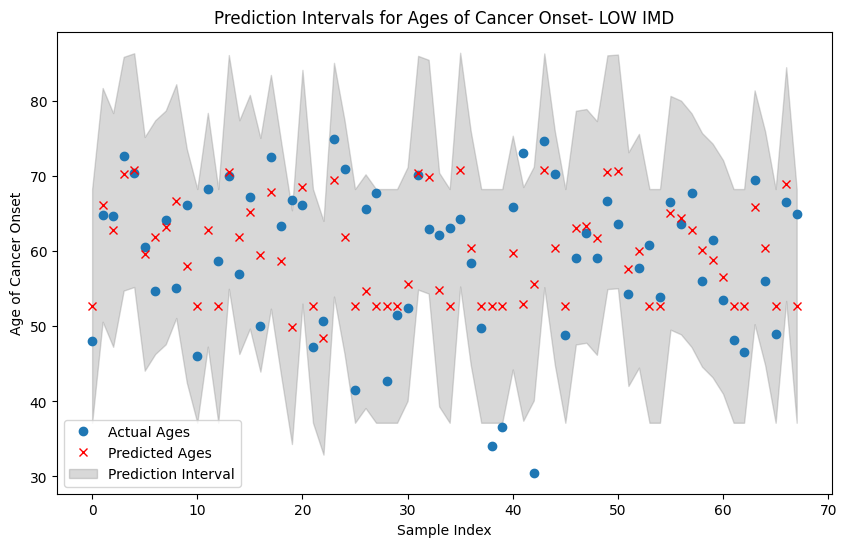

In [259]:
#Plotting the prediction intervals for ages of cancer onset
#Overlaying the test and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_low.values, 'o', label='Actual Ages')
plt.plot(y_pred_low, 'x', label='Predicted Ages', color='red')
plt.fill_between(range(len(y_pred_low)), lower_bound_low, upper_bound_low, color='gray', alpha=0.3, label='Prediction Interval')
plt.xlabel('Sample Index')
plt.ylabel('Age of Cancer Onset')
plt.title('Prediction Intervals for Ages of Cancer Onset- LOW IMD')
plt.legend()
plt.show()


Prediction interval plot for HIGH MODEL

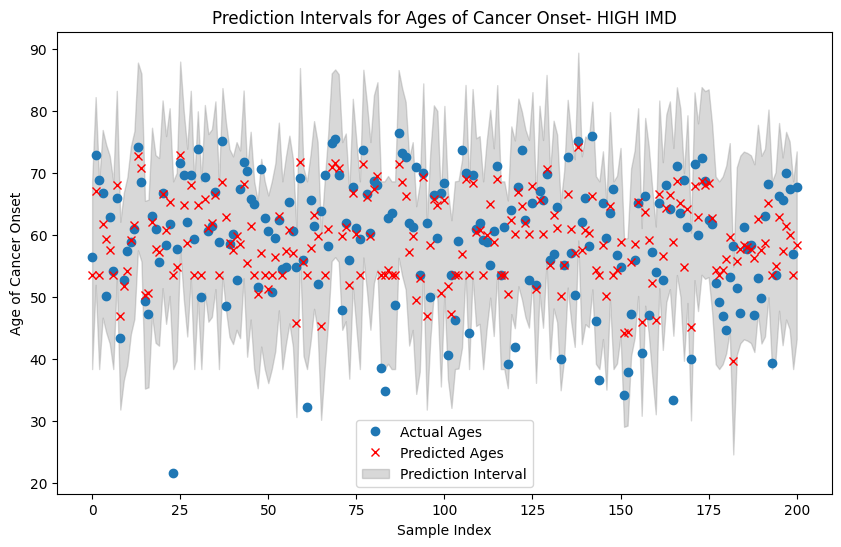

In [260]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_high.values, 'o', label='Actual Ages')
plt.plot(y_pred_high, 'x', label='Predicted Ages', color='red')
plt.fill_between(range(len(y_pred_high)), lower_bound_high, upper_bound_high, color='gray', alpha=0.3, label='Prediction Interval')
plt.xlabel('Sample Index')
plt.ylabel('Age of Cancer Onset')
plt.title('Prediction Intervals for Ages of Cancer Onset- HIGH IMD')
plt.legend()
plt.show()

SAVING THE TRAINING AND TESTING DATA IN THE LOCAL ENVIRONMENT.

In [261]:
X_train_high.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/X_train_high.csv")
y_train_high.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/y_train_high.csv")
X_train_low.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/X_train_low.csv")
y_train_low.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/y_train_low.csv")

In [262]:
#Resetting the index so the eid column is a column in the data frame and does not disappear while saving the file
X_train_high= X_train_high.reset_index('eid')

In [263]:
X_train_high= X_train_high.drop(columns= ['eid'])

In [264]:
X_train_high.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/X_train_high.csv")

In [265]:
y_train_high= y_train_high.reset_index('eid')
y_train_high= y_train_high.drop(columns= ['eid'])
y_train_high.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/y_train_high.csv")

In [266]:
X_train_low= X_train_low.reset_index('eid')
X_train_low= X_train_low.drop(columns= ['eid'])
X_train_low.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/X_train_low.csv")

In [267]:
y_train_low= y_train_low.reset_index('eid')
y_train_low= y_train_low.drop(columns= ['eid'])
y_train_low.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/y_train_low.csv")

In [268]:
X_test_low= X_test_low.reset_index('eid')
X_test_low= X_test_low.drop(columns= ['eid'])
X_test_low.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/X_test_low.csv")

In [269]:
y_test_low= y_test_low.reset_index('eid')
y_test_low= y_test_low.drop(columns= ['eid'])
y_test_low.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/y_test_low.csv")

In [270]:
X_test_high= X_test_high.reset_index('eid')
X_test_high= X_test_high.drop(columns= ['eid'])

In [271]:
X_test_high.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/X_test_high.csv")

In [272]:
y_test_high= y_test_high.reset_index('eid')
y_test_high= y_test_high.drop(columns= ['eid'])
y_test_high.to_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/y_test_high.csv")